# EL Hackathon 2025: Spatial Cell-Type Prediction EDA

# 1. Introduction
This notebook provides an exploratory data analysis (EDA) of the EL Hackathon 2025 dataset, which consists of:

* H&E-stained histology images (6 training slides, 1 test slide)

* Spatial transcriptomics (SRT)-derived cell-type compositions (~10k spots, 35 cell types)

* Goal: Predict cell-type abundances (C1–C35) for each spot (~55 µm diameter) using only H&E images

In [1]:
# Import libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set style
plt.style.use('ggplot')
sns.set_palette('viridis')

## 2. Data Loading & Overview
We first load the data from the provided HDF5 file and inspect its structure

In [2]:
# Load and inspect HDF5 file structure
data_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"

with h5py.File(data_path, "r") as f:
    print("HDF5 Groups:", list(f.keys()))
    train_slides = list(f["images/Train"].keys())
    test_slide = list(f["images/Test"].keys())
    
print("\nTraining Slides:", train_slides)
print("Test Slide:", test_slide)

HDF5 Groups: ['images', 'spots']

Training Slides: ['S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6']
Test Slide: ['S_7']


***Observations:***

* 6 training slides (S_1 to S_6) and 1 test slide (S_7)

* Data is stored in two groups:

  - images/: Contains H&E-stained tissue images
  - spots/: Contains spot coordinates and cell-type abundances

## 3. Visualizing H&E Slides with Spots
We visualize H&E images with overlaid spot locations to understand tissue structure

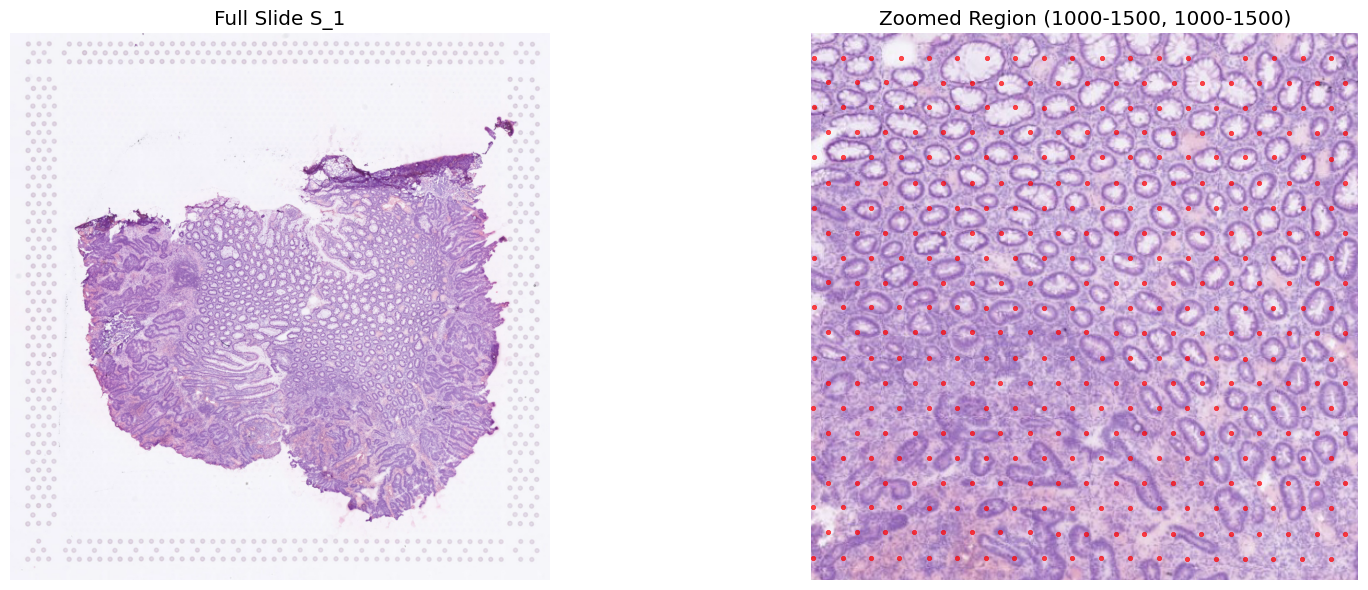

In [3]:
def plot_slide_with_spots(slide_name, h5_file, zoom_region=None):
    """Plot H&E image with spot coordinates, optionally zoomed to a region"""
    with h5py.File(h5_file, "r") as f:
        image = np.array(f[f"images/Train/{slide_name}"])
        spots = pd.DataFrame(np.array(f[f"spots/Train/{slide_name}"]))
    
    fig, ax = plt.subplots(1, 1 + int(zoom_region is not None), 
                         figsize=(18, 6) if zoom_region else (10, 10))
    
    if zoom_region:
        x1, x2, y1, y2 = zoom_region
        zoom_img = image[y1:y2, x1:x2]
        zoom_spots = spots[(spots['x'].between(x1, x2)) & 
                          (spots['y'].between(y1, y2))]
        
        ax[0].imshow(image)
        ax[0].set_title(f"Full Slide {slide_name}")
        ax[1].imshow(zoom_img)
        ax[1].scatter(zoom_spots["x"]-x1, zoom_spots["y"]-y1, 
                     s=10, c="red", alpha=0.7)
        ax[1].set_title(f"Zoomed Region ({x1}-{x2}, {y1}-{y2})")
    else:
        ax.imshow(image)
        ax.scatter(spots["x"], spots["y"], s=5, c="red", alpha=0.5)
        ax.set_title(f"Slide {slide_name} | Spots: {len(spots)}")
    
    for a in fig.axes:
        a.axis('off')
    plt.tight_layout()
    plt.show()
plot_slide_with_spots(train_slides[0], data_path, 
                     zoom_region=(1000, 1500, 1000, 1500))

***Observations:***

* Spots are uniformly distributed across tissue regions

* Some slides show higher spot density 

* Test slide (S_7) has a similar distribution

## 4. Analyzing Cell-type Composition
We analyze the distribution of cell-type abundances (C1–C35) across spots

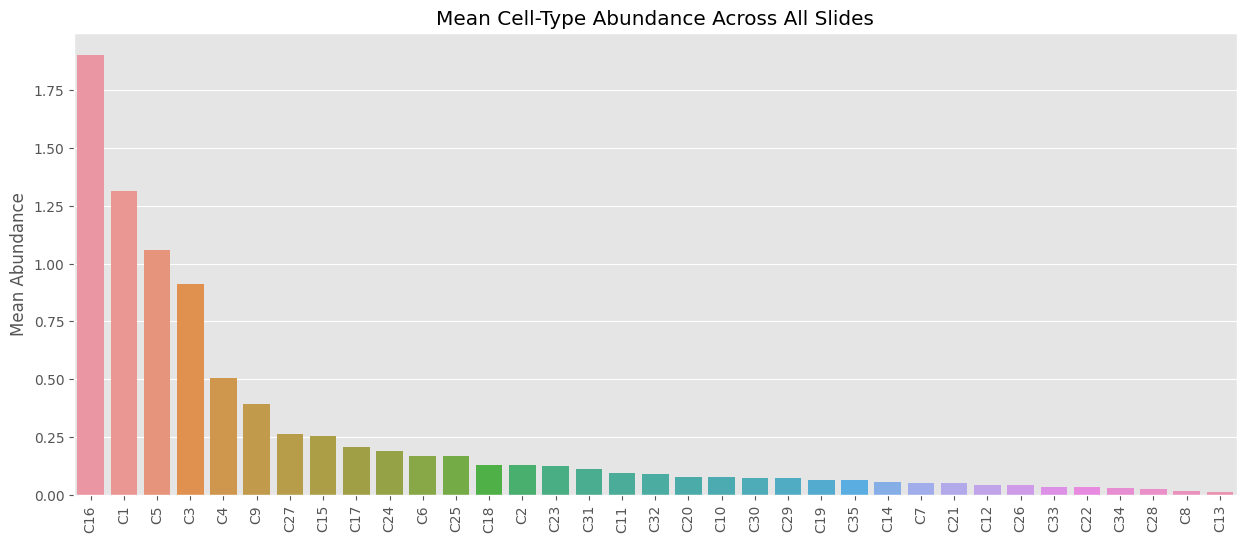

In [4]:
# Load cell-type data for all slides
cell_data = []
for slide in train_slides:
    with h5py.File(data_path, "r") as f:
        spots = pd.DataFrame(np.array(f[f"spots/Train/{slide}"]))
        cell_data.append(spots.iloc[:, 2:37])  # Columns C1-C35

cell_types = [f"C{i}" for i in range(1, 36)]
all_cell_data = pd.concat(cell_data)

# Plot distribution of mean abundances
plt.figure(figsize=(15, 6))
mean_abundance = all_cell_data.mean().sort_values(ascending=False)
sns.barplot(x=mean_abundance.index, y=mean_abundance.values)
plt.xticks(rotation=90)
plt.title("Mean Cell-Type Abundance Across All Slides")
plt.ylabel("Mean Abundance")
plt.show()

***Observations:***

* Some cell types (e.g., C16, C1, C5, C3) are highly abundant

* Others (e.g., C13, C8, C28...) are rare

* *Class imbalance exists = Consider weighted loss in modeling*

## 5. Spatial Distribution of Cell Types

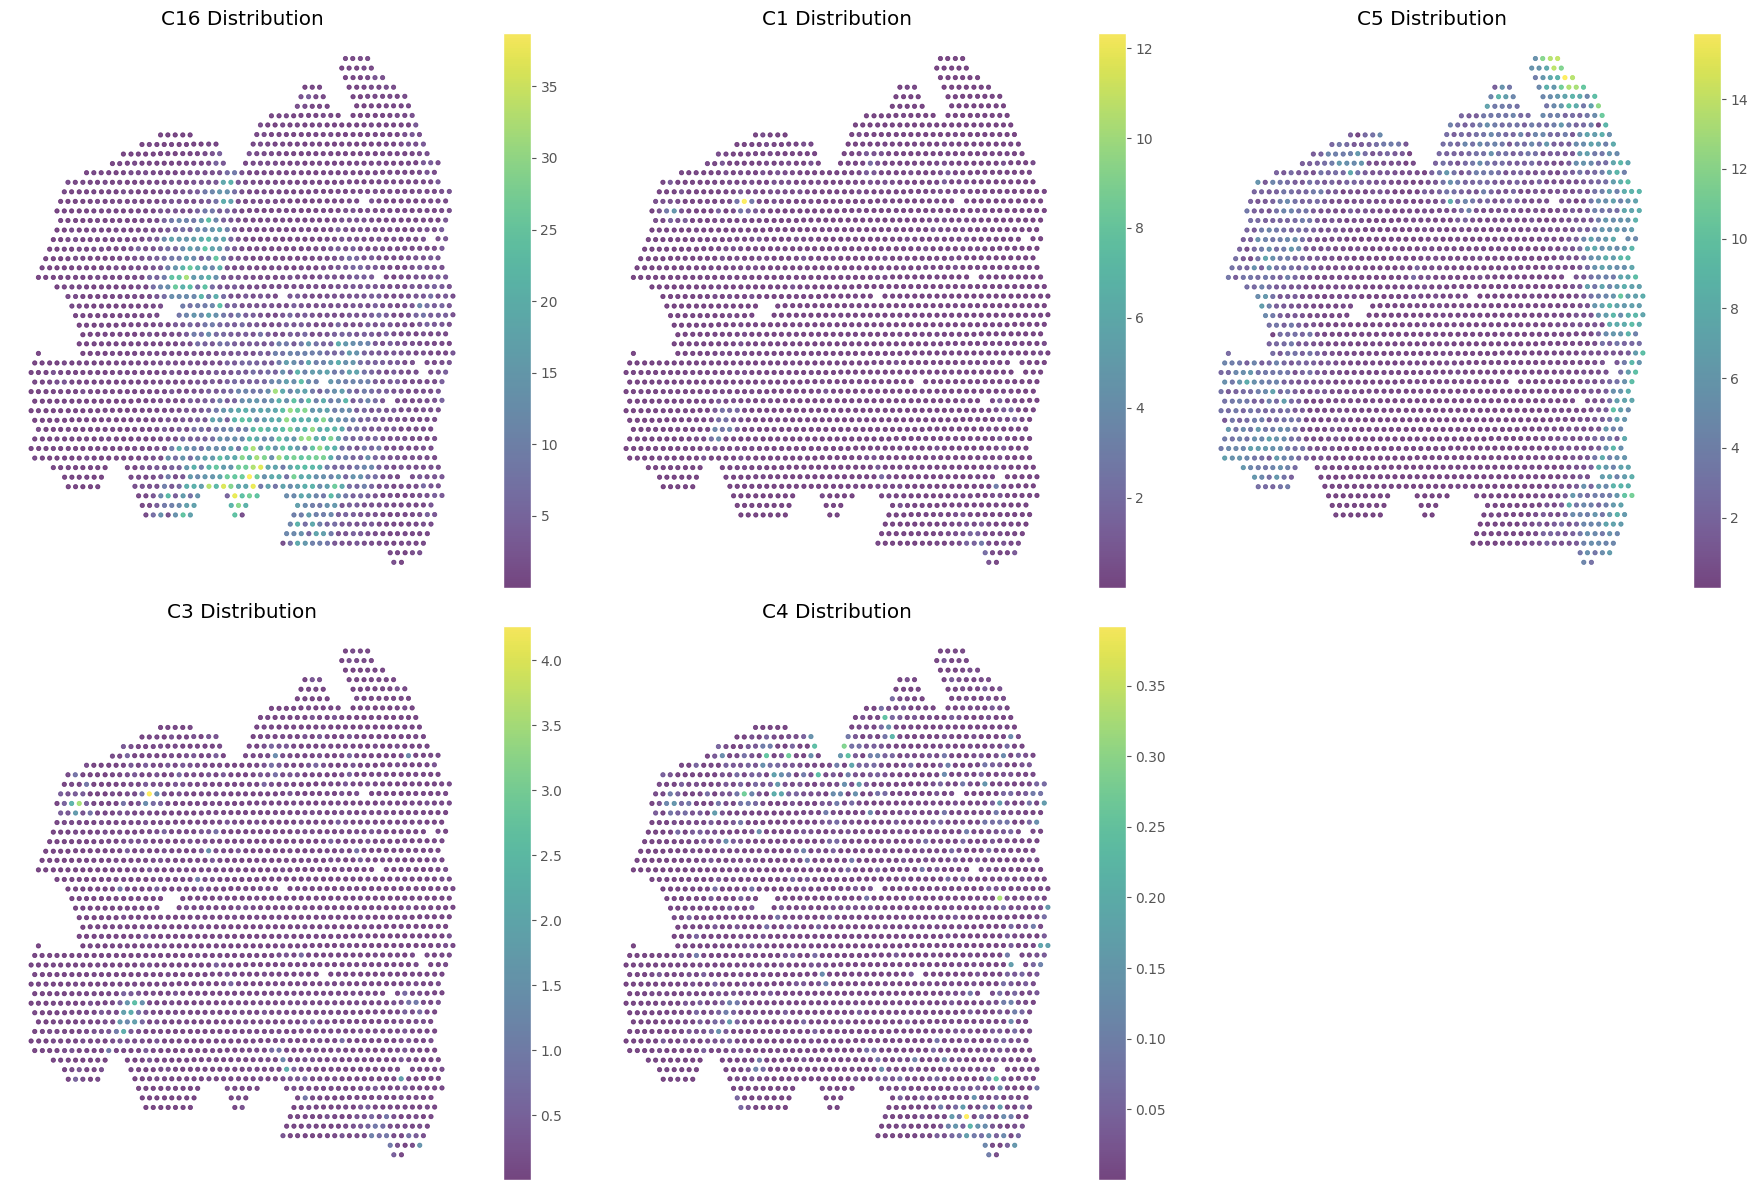

In [5]:
# Plot spatial distribution of top 5 cell types
top_cell_types = mean_abundance.index[:5]

with h5py.File(data_path, "r") as f:
    image = np.array(f["images/Train/S_1"])
    spots = pd.DataFrame(np.array(f["spots/Train/S_1"]))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, cell_type in enumerate(top_cell_types):
    sc = axes[i].scatter(
        spots["x"], 
        spots["y"], 
        c=spots[cell_type], 
        cmap="viridis", 
        s=10,
        alpha=0.7
    )
    axes[i].set_title(f"{cell_type} Distribution")
    plt.colorbar(sc, ax=axes[i])
    axes[i].axis('off')

# Remove empty subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

***Observations:***

* Some cell types (e.g. C16) form clusters

* Others (e.g., C4) are diffusely distributed

* Spatial patterns suggest local correlations = Useful for graph neural networks

## 6. Cell-Type Correlations

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


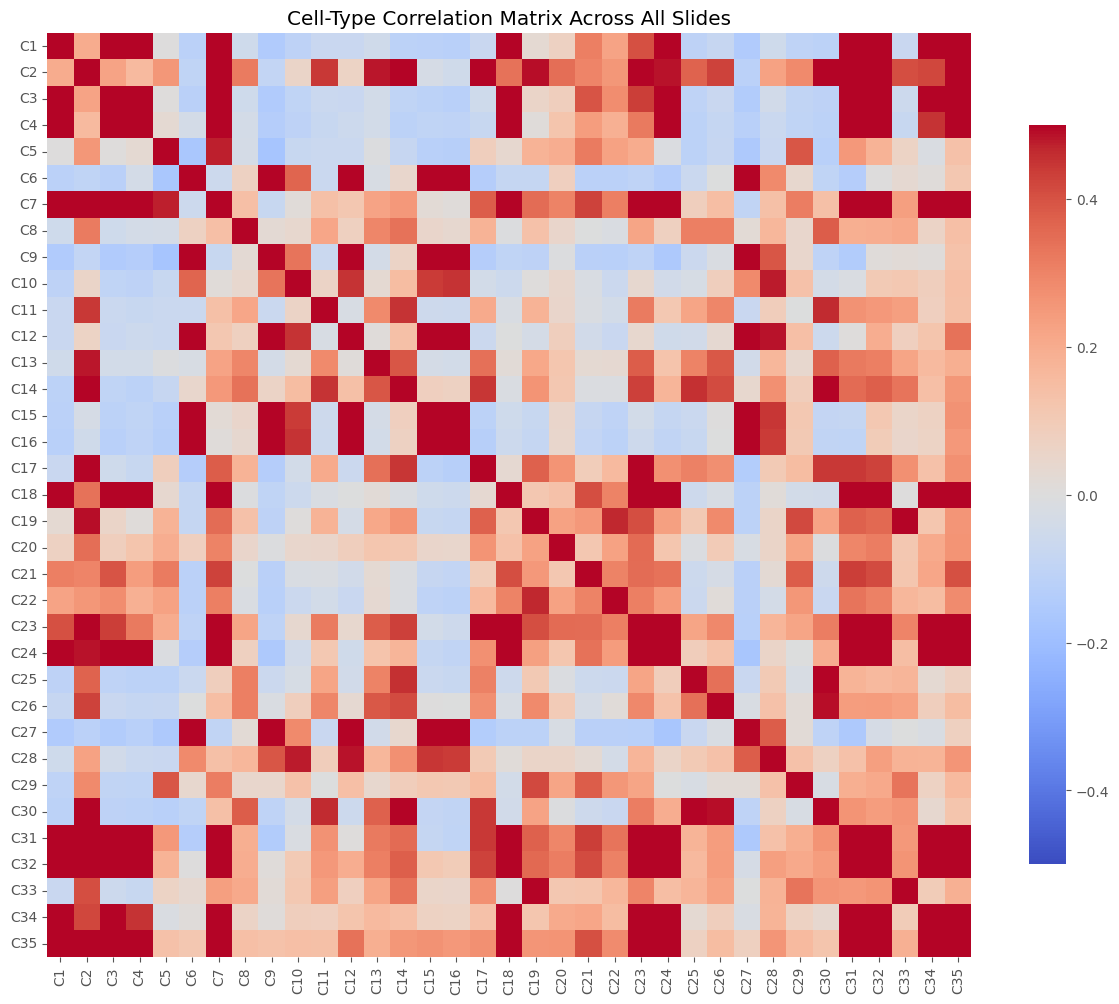

In [6]:
# Compute and plot correlation matrix
corr_matrix = all_cell_data.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    vmin=-0.5, 
    vmax=0.5,
    center=0,
    square=True,
    annot=False,
    cbar_kws={"shrink": 0.8}
)
plt.title("Cell-Type Correlation Matrix Across All Slides")
plt.show()

***Observations:***

* Some cell types (e.g., C1 & C35) are positively correlated

* Others (e.g., C1 & C33) are negatively correlated.

* Multi-task learning may help leverage these relationships.

## 7. Key Takeaways & Discussion

###  Key Observations:
1. **Data Structure**: 
   - 6 training slides with ~2000 spots each
   - 35 cell types with varying abundances

2. **Cell-Type Distribution**:
   - Significant class imbalance (some types very rare)
   - Spatial clustering evident for certain types

3. **Correlations**:
   - Both positive and negative correlations exist between cell types

###  Discussion Points:
- How should we handle rare cell types?
- What spatial modeling approaches work best?
- Should we use domain-specific pretrained models?